In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Append custom library path (if you have a library to include)
import sys
custom_library_path = '/content/drive/MyDrive/your_custom_library'  # Update if you have any custom library
sys.path.append(custom_library_path)



Mounted at /content/drive


In [ ]:
# Activate GPU for training
!nvidia-smi

Fri Nov  8 01:22:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

In [ ]:
# Step 3: Paths for images and masks
covid_path = "/content/drive/MyDrive/extracted_files/Pre-processing data/COVID19_xrays"
noncovid_path = "/content/drive/MyDrive/extracted_files/Pre-processing data/NonCOVID19_xrays"
normal_path = "/content/drive/MyDrive/extracted_files/Pre-processing data/Normal_xrays"

covid_mask_path = "/content/drive/MyDrive/extracted_files/Pre-processing data/lung_masks_COVID19"
noncovid_mask_path = "/content/drive/MyDrive/extracted_files/Pre-processing data/lung_masks_NonCOVID"
normal_mask_path = "/content/drive/MyDrive/extracted_files/Pre-processing data/lung_masks_Normal"

In [ ]:
# Parameters
num_images = 1000
image_size = 256
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load image and mask file paths
def load_image_mask_paths(image_path, mask_path, num_images):
    image_files = os.listdir(image_path)[:num_images]
    image_paths = [os.path.join(image_path, img) for img in image_files]
    mask_paths = [os.path.join(mask_path, img) for img in image_files]
    return image_paths, mask_paths


In [ ]:
# Load data paths
covid_image_paths, covid_mask_paths = load_image_mask_paths(covid_path, covid_mask_path, num_images)
noncovid_image_paths, noncovid_mask_paths = load_image_mask_paths(noncovid_path, noncovid_mask_path, num_images)
normal_image_paths, normal_mask_paths = load_image_mask_paths(normal_path, normal_mask_path, num_images)

# Create labels
covid_labels = np.zeros(len(covid_image_paths))
noncovid_labels = np.ones(len(noncovid_image_paths))
normal_labels = np.full(len(normal_image_paths), 2)

# Combine data
image_paths = covid_image_paths + noncovid_image_paths + normal_image_paths
mask_paths = covid_mask_paths + noncovid_mask_paths + normal_mask_paths
labels = np.concatenate((covid_labels, noncovid_labels, normal_labels), axis=0)

# Split data into train, validation, and test sets
train_image_paths, test_image_paths, train_labels, test_labels, train_mask_paths, test_mask_paths = train_test_split(
    image_paths, labels, mask_paths, test_size=0.3, random_state=42)
val_image_paths, test_image_paths, val_labels, test_labels, val_mask_paths, test_mask_paths = train_test_split(
    test_image_paths, test_labels, test_mask_paths, test_size=0.5, random_state=42)

# Define custom Dataset class
class XRayDataset(Dataset):
    def __init__(self, image_paths, mask_paths, labels, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and mask on-the-fly
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            raise ValueError(f"Error loading image or mask at index {idx}")

        image = cv2.resize(image, (image_size, image_size)) / 255.0
        mask = cv2.resize(mask, (image_size, image_size)) / 255.0

        # Apply mask to the image
        image = image * mask
        image = np.stack([image, image, image], axis=-1)  # Convert to 3 channels for ResNet50

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Define transformations for data augmentation and normalization for training dataset
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Add perspective distortion
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),  # Add Gaussian blur
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Define transformations for validation and test datasets (no augmentation, just normalization)
val_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [ ]:
# Create datasets and data loaders
train_dataset = XRayDataset(train_image_paths, train_mask_paths, train_labels, transform=train_transform)
val_dataset = XRayDataset(val_image_paths, val_mask_paths, val_labels, transform=val_test_transform)
test_dataset = XRayDataset(test_image_paths, test_mask_paths, test_labels, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

# Load pre-trained ResNet50 model
resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

resnet50.fc = nn.Sequential(
    nn.Linear(resnet50.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),  # Reduced dropout rate
    nn.BatchNorm1d(512),
    nn.Linear(512, 3)
)  # Modify the output layer for 3 classes with dropout and batch normalization
resnet50 = resnet50.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.0003, weight_decay=1e-4)  # Lower learning rate and add L2 regularization
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)  # Use cosine annealing scheduler
reduce_lr_on_plateau = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)  # Reduce LR on plateau



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 202MB/s]


In [ ]:
# Training loop
num_epochs = 10
early_stopping_patience = 5
best_val_loss = float('inf')
early_stopping_counter = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    resnet50.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, dtype=torch.long, non_blocking=True)

        # Forward pass
        outputs = resnet50(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        # Gradient clipping
        nn.utils.clip_grad_norm_(resnet50.parameters(), max_norm=2.0)
        optimizer.step()

        running_loss += loss.item()

    # Validation
    resnet50.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, dtype=torch.long, non_blocking=True)
            outputs = resnet50(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Update learning rate scheduler
    scheduler.step()
    reduce_lr_on_plateau.step(val_loss / len(val_loader))

    train_loss_avg = running_loss / len(train_loader)
    val_loss_avg = val_loss / len(val_loader)
    train_losses.append(train_loss_avg)
    val_losses.append(val_loss_avg)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss_avg:.4f}, Validation Loss: {val_loss_avg:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

print("Training complete.")


Epoch [1/10], Loss: 0.8104, Validation Loss: 0.8528
Epoch [2/10], Loss: 0.5873, Validation Loss: 0.6758
Epoch [3/10], Loss: 0.5405, Validation Loss: 0.6492
Epoch [4/10], Loss: 0.4762, Validation Loss: 0.4854
Epoch [5/10], Loss: 0.4448, Validation Loss: 0.3651
Epoch [6/10], Loss: 0.3941, Validation Loss: 0.3632
Epoch [7/10], Loss: 0.3616, Validation Loss: 0.3661
Epoch [8/10], Loss: 0.3135, Validation Loss: 0.4265
Epoch [9/10], Loss: 0.2783, Validation Loss: 0.4298
Epoch [10/10], Loss: 0.2769, Validation Loss: 0.3867
Training complete.


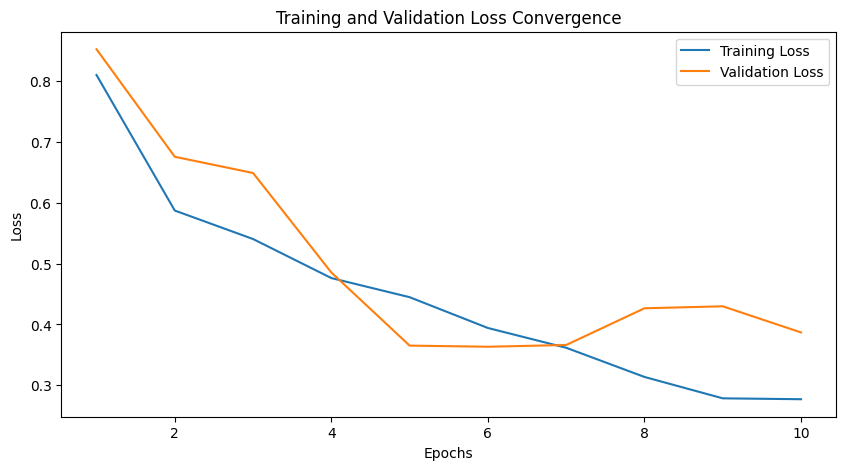

In [ ]:
# Plot convergence
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Convergence')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# Evaluate on test set
resnet50.eval()
test_preds = []
test_targets = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, dtype=torch.long, non_blocking=True)
        outputs = resnet50(images)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_targets, test_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")
print("Classification Report:")
print(classification_report(test_targets, test_preds, target_names=['COVID', 'Non-COVID', 'Normal']))


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Accuracy: 0.8156
Classification Report:
              precision    recall  f1-score   support

       COVID       0.98      0.74      0.84       151
   Non-COVID       0.75      0.91      0.82       152
      Normal       0.78      0.80      0.79       147

    accuracy                           0.82       450
   macro avg       0.83      0.82      0.82       450
weighted avg       0.84      0.82      0.82       450



In [ ]:
import torch
from torch.utils.data import get_worker_info

# Get worker information if available (will be None if num_workers is 0)
worker_info = get_worker_info()

if worker_info is not None:
    # Get the recommended number of workers from PyTorch
    num_workers = worker_info.num_workers
    print(f"Recommended num_workers: {num_workers}")
else:
    # If num_workers is 0, use a default value
    num_workers = 0  # Or you could use a different default
    print("No worker information available, using default num_workers:", num_workers)


No worker information available, using default num_workers: 0
